# Depth Prediction Example with StereoNet

In [1]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "stereonet")
sys.path.append(wd)

In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from models import StereoNet

In [3]:
checkpt_path = "stereonet/checkpts/IRS.pth"
max_disp = 128
device = 'cuda'

### Load model from checkpoint

In [4]:
model = StereoNet(k=3, r=3, maxdisp=max_disp)
model.to(device)
checkpt = torch.load(checkpt_path)
model.load_state_dict(checkpt['state_dict'])

<All keys matched successfully>

### Predict depth from input images

In [5]:
data_path = "imgs/IRS"
l_img_path = os.path.join(data_path, "l_157.png")
r_img_path = os.path.join(data_path, "r_157.png")
disp_path = os.path.join(data_path, "d_157.exr")

l_img = Image.open(l_img_path).convert('RGB')
r_img = Image.open(r_img_path).convert('RGB')
disp = cv2.imread(disp_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
disp = disp[:,:,1]

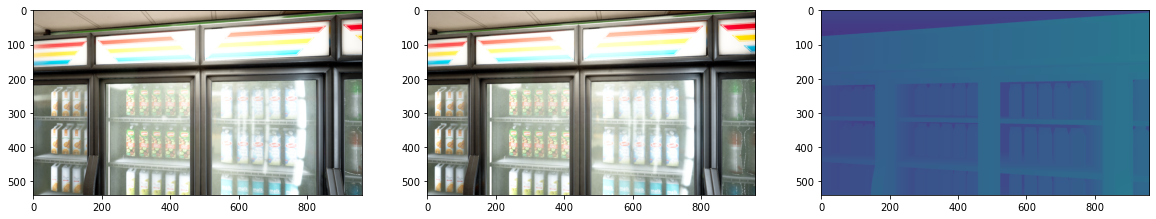

In [6]:
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(l_img)
plt.subplot(132)
plt.imshow(r_img)
plt.subplot(133)
plt.imshow(disp, vmin=0, vmax=max_disp)

In [7]:
l_img_tensor = transforms.ToTensor()(l_img)
r_img_tensor = transforms.ToTensor()(r_img)

l_img_tensor = torch.unsqueeze(l_img_tensor, dim=0)
r_img_tensor = torch.unsqueeze(r_img_tensor, dim=0)

l_img_tensor = l_img_tensor.to(device)
r_img_tensor = r_img_tensor.to(device)

with torch.no_grad():
    model.eval()
    outputs = model(l_img_tensor, r_img_tensor)
pred_disp = outputs[1].detach().cpu().numpy()
pred_disp = np.squeeze(pred_disp)

### Print prediction results and error metrics

In [8]:
pixel_num = disp.size
diff = np.abs(pred_disp - disp)
bad3 = diff > 3
bad3 = np.sum(bad3)
bad3 = bad3 / pixel_num * 100.0

epe = np.sum(diff)
epe = epe / pixel_num

print("Bad3 for model output: %.4f" % bad3)
print("EPE for model output: %.4f" % epe)

Bad3 for model output: 14.8927
EPE for model output: 1.7868


Text(0.5, 1.0, 'Pred Disp')

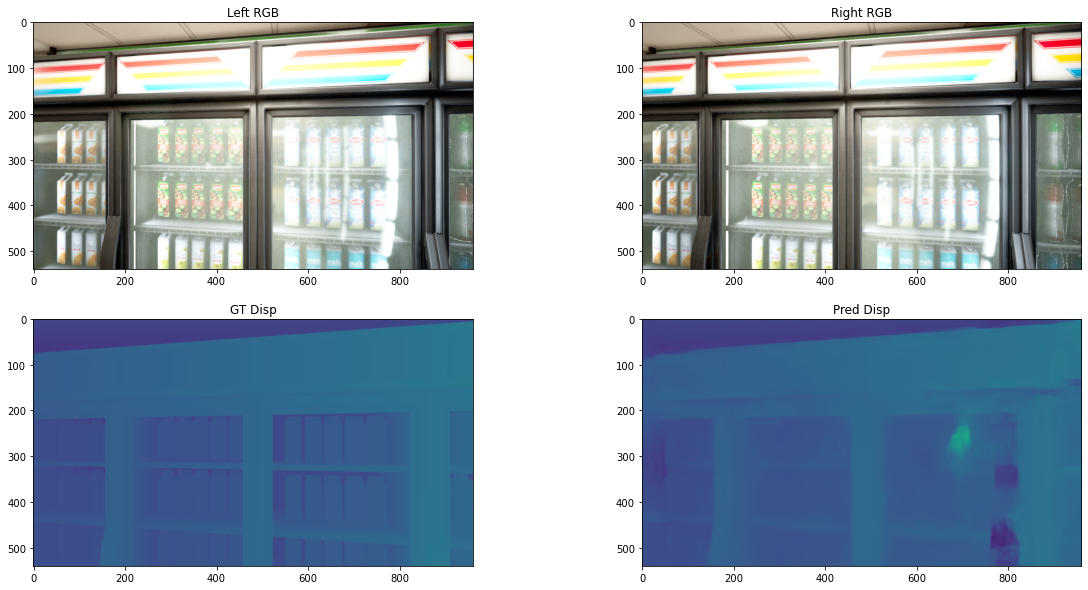

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(l_img)
plt.title("Left RGB")
plt.subplot(222)
plt.imshow(r_img)
plt.title("Right RGB")
plt.subplot(223)
plt.imshow(disp, vmin=0, vmax=max_disp)
plt.title("GT Disp")
plt.subplot(224)
plt.imshow(pred_disp, vmin=0, vmax=max_disp)
plt.title("Pred Disp")

### Print baseline (SGBM) and error metrics

In [10]:
stereo = cv2.StereoSGBM_create(numDisparities=max_disp, blockSize=7)
l_img_cv2 = cv2.imread(l_img_path)
r_img_cv2 = cv2.imread(r_img_path)
SGBM_disp = stereo.compute(l_img_cv2, r_img_cv2)
SGBM_disp = SGBM_disp / 16.0

In [11]:
pixel_num = disp[:, 128:].size
diff = np.abs(SGBM_disp[:, max_disp:] - disp[:, max_disp:])  # exclude the left x columns (x = max_disp)
bad3 = diff > 3
bad3 = np.sum(bad3)
bad3 = bad3 / pixel_num * 100.0

epe = np.sum(diff)
epe = epe / pixel_num

print("Bad3 for SGBM output: %.4f" % bad3)
print("EPE for SGBM output: %.4f" % epe)

Bad3 for SGBM output: 35.2301
EPE for SGBM output: 9.8464


Text(0.5, 1.0, 'SGBM Disp')

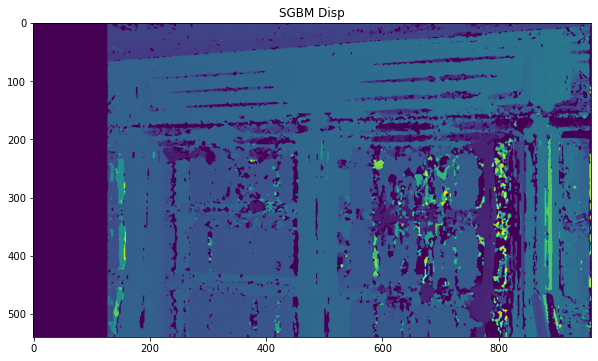

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(SGBM_disp, vmin=0, vmax=max_disp)
plt.title("SGBM Disp")